In [4]:
%%capture
#Imaporta a rede VGG19 ja treinada
from keras.applications.vgg19 import VGG19
#Pre-processamento da imagem
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
#Biblioteca para operar sobre o modelo
from keras import models
#Salvar os modelos dos SOMs em arquivos
import pickle
#Visualizacao dos resultados
import matplotlib.pyplot as plt
#Ferramentas matematicas
import numpy as np
from math import sqrt
from random import randint
from numpy import argmax
#Self Organizing Maps(SOMs)
from minisom import MiniSom
#Ferramentas para pegar a lista de imagens
import glob
import os
import natsort 

In [5]:
%%capture
#Carrega o modelo ja treinado
model = VGG19()

In [3]:
%%capture
#model.summary()

In [20]:
%%capture
class SymbolicLayer:
    
    def __init__(self, cnn_input_layer, learning_rate = 0.05, sigma = 3):
        #cnn_input_layer - numero da camada da CNN da qual sera retirado o feature map de entrada da camada
        self.cnn_input_layer = cnn_input_layer 
        self.learning_rate = learning_rate 
        self.sigma = sigma
        #Variaveis cradas na layerCreate
        self.layer_input_size = None #Numero de elementos do feature vector de entrada: 235711
        self.soms_num = None #Numero de SOMs na entrada dessa camada: 2
        self.soms_sizes = None #Arranjo com as dimensoes de cada SOM: ((10, 10), (15, 15))
        self.output_size = None #Arranjo com as dimensoes do SOM de saida: (30, 30)
        self.layer_branches = None #Arranjo com cada SOM da camada
        self.soms_input_size = None #Tamanho do input de cada SOM - é o mesmo para todas: 2343
        self.last_layer_input_size = None #Numero de elementos na entrada do SOM de saida: 4500
        self.out_layer = None #SOM de saida
        
        
    #--------------------------------------------------------------------------
     
    def layerCreate(self, layer_input_size, soms_num, soms_sizes, output_size):
        self.layer_input_size = layer_input_size
        self.output_size = output_size
        self. soms_num = soms_num
        self.soms_sizes = soms_sizes
        
        #Criar o arranjo com os SOMs daquela camada
        self.layer_branches = []
        self.soms_input_size = self.layer_input_size/self.soms_num
        for i in range(self.soms_num):
            self.layer_branches.append(MiniSom(int(self.soms_sizes[i][0]), int(self.soms_sizes[i][1]), int(self.soms_input_size), self.sigma, self.learning_rate))  
         
        #Calcular o numero de elementos que entrarão na camada de saida
        self.last_layer_input_size = sum(np.prod(som_shape) for som_shape in self.soms_sizes)
        
        #Criar a camada de saida
        self.out_layer = MiniSom(int(self.output_size[0]), int(self.output_size[1]), self.last_layer_input_size, self.sigma, self.learning_rate)
    #--------------------------------------------------------------------------
        
    def layerTrain(self, train_feature_map, trains_per_image=2):
        #train_feature_map - Feature map que sera o input da camada
        #trains_per_image - Numero de vezes que um mesmo feature map sera usado no treino das SOMs de entrada
        
        #Dividir o feature map de entrada e treinar cada SOM de entrada com a sua parcela correspondente
        layer_input = []
        for i in range(self.soms_num):
            #print(i, ' ', np.shape(train_feature_map))
            feature_map = train_feature_map[int(i*self.soms_input_size):int((i+1)*self.soms_input_size)]
            #print(np.shape(feature_map))
            feature_map = feature_map.reshape(np.prod(np.shape(feature_map)))
            self.layer_branches[i].train([feature_map], trains_per_image)
            layer_input.append(np.reshape( self.layer_branches[i].activate(feature_map), (int(self.soms_sizes[i][0])*int(self.soms_sizes[i][1]))))
            
        #Concatenar a saida gerada pelas SOMs de entrada e linearizar
        layer_input = np.concatenate(layer_input)
        layer_input = np.reshape(layer_input, (1, self.last_layer_input_size))
        #Treina o SOM de saida com o feature vector das SOMs de entrada
        self.out_layer.train(layer_input, trains_per_image)
        return (self.out_layer.activate(layer_input))
    #--------------------------------------------------------------------------
    
    def layerGenerateMap(self, feature_map, change=True):
        #feature_map - Feature map do qual sera gerado o mapa
        
        #Separar o feature map entre os SOMs de entrada e gerar os mapas
        layer_input = []
        for i in range(self.soms_num):
            partial_feature_map = feature_map[int(i*self.soms_input_size):int((i+1)*self.soms_input_size)]
            partial_feature_map = partial_feature_map.reshape((int(self.soms_input_size)))
            layer_input.append(np.reshape( self.layer_branches[i].activate(partial_feature_map), (int(self.soms_sizes[i][0])*int(self.soms_sizes[i][1]))))
        
        #Concatenar e redimensionar os mapas de saida dos SOMs de entrada
        layer_input = np.concatenate(layer_input)
        layer_input = np.reshape(layer_input, (1, self.last_layer_input_size))
        
        #Gerar o mapa de saida
        out = self.out_layer.activate(layer_input)
        
        #Normalizar os dados (0 <= x <= 1), Inverter o mapa (por algum motivo fica melhor), Zerar os valores menores que um limite (tirar interferencia)
        f_min, f_max = np.amin(out), np.amax(out)
        out = (out - f_min) / (f_max - f_min)
        if(change):
            out -= 1
            for j in range(np.shape(out)[0]):
                for k in range(np.shape(out)[1]):
                    if(out[j][k] < 0.7): out[j][k] = 0
        return out
    #--------------------------------------------------------------------------
    
    def layerSave(self, layer_path):
        #Nome dos arquivos dos SOMs
            #SOMs de entrada
                #som_in_"somNum"_"somDim".p
                    #somNum - numero daquele SOM na sub layer: 0
                    #somDim - uma das dimensoes do SOM: 30
            #SOM de saida
                #som_out.p

        #Iterar pelos SOMs da sub layer e salva los de acordo com o nome definido
        som_cont = 0
        for som in self.layer_branches:
            som_filename = layer_path+"/somin_"+str(som_cont)+"_"+str(self.soms_sizes[som_cont][0])+"_.p"
            # saving the som in the file som.p
            with open(som_filename, 'wb') as outfile:
                pickle.dump(som, outfile)
            som_cont += 1

        #Salvar o SOM de saida
        out_layer_path = layer_path+"/somout.p"
        with open(out_layer_path, 'wb') as outfile:
            pickle.dump(self.out_layer, outfile)
    #--------------------------------------------------------------------------
    
    def layerLoad(self, layer_path):
        #Pegar as informacoes da camada pelo nome da pasta
        layer_infos = layer_path.split("/")[-1]
        layer_infos = layer_infos.split("_")[2:]
        #Definir as variaveis da camada
        self.layer_input_size = int(layer_infos[0])
        self.output_size = (int(layer_infos[1]), int(layer_infos[1]))
        self.soms_num = int(layer_infos[2])
               
        self.soms_sizes = []
        self.layer_branches = []
        self.soms_input_size = self.layer_input_size/self.soms_num
        
        #Pegar os nomes de todos os arquivos na pasta
        soms_filenames = []
        os.chdir(layer_path+"/")
        for file_name in glob.glob("*.p"):
            file_name = "/"+file_name
            if(file_name != "/somout.p"):
                soms_filenames.append(file_name)        
        soms_filenames = natsort.natsorted(soms_filenames,reverse=False)

        #Carregar todos os SOMs de entrada
        for filename in soms_filenames:
            infos = filename.split("_")[:-1]
            if(infos[0] == "/somin"):
                with open(layer_path+filename, 'rb') as infile:
                    self.layer_branches.append(pickle.load(infile))
                    self.soms_sizes.append((int(infos[2]), int(infos[2])))
        self.last_layer_input_size = sum(np.prod(som_shape) for som_shape in self.soms_sizes)
        
        #Carregar o som de saida
        with open(layer_path+"/somout.p", 'rb') as infile:
            self.out_layer = pickle.load(infile)  
        
        #Retornar as dimensoes dos SOMs para salvar nos parametros da rede
        return self.soms_sizes
#------------------------------------------------------------------------------------------------------------------------------------------------------------------    

In [21]:
%%capture
class SymbolicNet:
    
    def __init__(self, cnn_model, out_sub_layer, learning_rate = 0.05, sigma = 3):
        self.out_sub_layer = out_sub_layer #Variavel booleana que define se a saida das sub layers de entrada passarao por uma 
            #terceira sub layer antes de saiir ou por um SOM (True - sub layer de saida)(False  - SOM de saida)
        self.cnn_model = cnn_model
        self.learning_rate = learning_rate
        self.sigma = sigma
        #Variaveis cradas na netCreate
        self.sub_layer_num = None #Numero de sub layers a serem criadas, cada uma recebendo uma camada da CNN: 3
        self.cnn_input_layer = None #Arranjo com os numeros das camadas da CNN das quais serao retiradas as entradas de cada sub layer: (2, 3, 5)
             #                                                                                             sub_layer_1      sub_layer_2  sub_layer_3
        self.sub_layer_som_num = None #Arranjo com o numero de SOMs em cada sub layer: (2, 1, 1)       -------------------  ---------    --------
        self.sub_layer_som_dim = None #Arrando triplo com as dimensoes de cada SOM em cada sub layer: (((15, 15), (10,10)), ((10, 10)), ((20, 20)))
        self.out_som_size = None #Arranjo com as dimensoes da saida de cada sub layer: ((7, 7), (5, 5), (8, 8))
        self.out_net_dim = None #Dimensoes da saida da rede: (40, 40) 
        self.activation_model = None #Modelo que ira pegar os feature maps das camadas da CNN selecionadas
        self.sub_layer_input_size = None #Numero de elementos na entrada de cada sub layer
        self.sub_layer = None #Arranjo com cada sub layer
        self.out_layer = None #SOM de saida da rede
        
        
        
    #--------------------------------------------------------------------------
    
    def netCreate(self, sub_layer_num, cnn_input_layer, sub_layer_som_num, sub_layer_som_dim, out_som_size, out_net_dim):
        self.sub_layer_num = sub_layer_num
        self.cnn_input_layer = cnn_input_layer
        self.sub_layer_som_num = sub_layer_som_num
        self.sub_layer_som_dim = sub_layer_som_dim
        self.out_som_size = out_som_size
        self.out_net_dim = out_net_dim
        
        
        #Criar o modelo que pegara as layers da CNN selecionadas
        layer_outputs = []
        for layer_index in self.cnn_input_layer:
            layer_outputs.append(self.cnn_model.layers[layer_index].output)
        self.activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
        
        #Pegar o numero de elementos na entrada de cada sub layer de entrada - numero de elementos na camada da CNN selecionada
        self.sub_layer_input_size = []
        for layer in self.cnn_input_layer:
            cnn_layer_shape = self.cnn_model.layers[layer].output_shape
            cnn_layer_size = 1
            for layer_dimension in cnn_layer_shape[1:]:
                cnn_layer_size *= layer_dimension
            self.sub_layer_input_size.append(cnn_layer_size)
        
        #Criar e inserir cada sub layer de entrada em um arranjo com as sublayer na ordem de entrada 
        self.sub_layer = []
        cont = 0
        for input_size in self.sub_layer_input_size:
            
            #Testar se o numero de SOMs na sub layer é divisisvel pelo tamanho do feature map de entrada e caso não seja aumentar até que se torne divisivel
            changed = False
            init_value = self.sub_layer_som_num[cont]
            while(input_size%self.sub_layer_som_num[cont] != 0):
                self.sub_layer_som_num[cont] += 1
                changed = True
            if(changed): 
                print("Quantidade de SOMs da", cont+1, " sub layer alterado de ", init_value, " para ", self.sub_layer_som_num[cont])
                #Adicionar no array de dimensoed dos SOMs daquela subleyer as dimensoes das sublayers criadas
                for i in range(self.sub_layer_som_num[cont] - init_value):
                    dim = randint(10, 20)
                    self.sub_layer_som_dim[cont].append((dim, dim))
            aux_sub_layer = SymbolicLayer(self.cnn_input_layer[cont])
            aux_sub_layer.layerCreate(input_size, self.sub_layer_som_num[cont], self.sub_layer_som_dim[cont], self.out_som_size[cont])
            self.sub_layer.append(aux_sub_layer)
            cont+=1
            
        #Criar o SOM de sida 
        out_layer_input_size = 0
        for sub_layer_shapes in out_som_size:
            out_layer_input_size += np.prod(sub_layer_shapes)
        if(self.out_sub_layer == False):
            self.out_layer = MiniSom(int(out_net_dim[0]), int(out_net_dim[1]), out_layer_input_size, self.sigma, self.learning_rate)

    #--------------------------------------------------------------------------
        
    def netTrain(self, training_data, verbose=True, verbose_num=200):
        if(verbose): 
            print("INICIO")
            total_training_data = len(training_data)
        #training_data - Array com os nomes das imagens nas quais será aplicado os treinamentos
        #verbose - Se vai imprimir as informacoes de treino
        #verbose_num - Quantidade de imagens por aviso
        num = 1
        #Tratar as imagens para se adequarem ao input da rede
        for image in training_data:
            img_aux = load_img('/home/gustavo/PROG/images/val2017/'+image, target_size=(224, 224))
            img_aux = img_to_array(img_aux)
            img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
            img_aux = preprocess_input(img_aux)
            
            #Passar a imagem pela rede e salvar a ativação das camadas escolhidas 
            cnn_layer_signal = self.activation_model.predict(img_aux)
            
            #Treinar cada sub layer com a ativação da sua camada
            index = 0
            out_layer_input = []
            for feature_map in cnn_layer_signal:
                feature_map = feature_map.reshape(np.prod(np.shape(feature_map)))
                aux_out_layer_input = self.sub_layer[index].layerTrain(feature_map, trains_per_image=10)
                aux_out_layer_input = np.reshape(aux_out_layer_input, np.prod(np.shape(aux_out_layer_input)))
                out_layer_input.append(aux_out_layer_input)
                index += 1
                
            #Concatenar as saidas de cada sub layer de entrada para criar um feture vector para a sub layer de saida
            out_layer_input = np.concatenate(out_layer_input)
            
            #Treinar a camada de saida com o feature vector gerado
            self.out_layer.train([out_layer_input], 1)
            if(verbose):
                if(num%verbose_num == 0): print("Concluido: ", num, "/", total_training_data)
            num+=1
        if(verbose): print("FIM")
    #--------------------------------------------------------------------------
            
    def netGenerateMap(self, image, change=False):
        img_aux = load_img('/home/gustavo/PROG/images/val2017/'+image, target_size=(224, 224))
        img_aux = img_to_array(img_aux)
        img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
        img_aux = preprocess_input(img_aux)

        #Passar a imagem pela rede e salvar a ativação das camadas escolhidas 
        cnn_layer_signal = self.activation_model.predict(img_aux)

        #Treinar cada sub layer com a ativação da sua camada
        index = 0
        out_layer_input = []
        for feature_map in cnn_layer_signal:
            feature_map = feature_map.reshape(np.prod(np.shape(feature_map)))
            aux_out_layer_input = self.sub_layer[index].layerGenerateMap(feature_map)
            aux_out_layer_input = np.reshape(aux_out_layer_input, np.prod(np.shape(aux_out_layer_input)))
            out_layer_input.append(aux_out_layer_input)
            index += 1

        #Concatenar as saidas de cada sub layer de entrada para criar um feture vector para a sub layer de saida
        out_layer_input = np.concatenate(out_layer_input)

        #Treinar a camada de saida com o feature vector gerado
        aux_out = self.out_layer.activate(out_layer_input)
        f_min, f_max = np.amin(aux_out), np.amax(aux_out)
        aux_out = (aux_out - f_min) / (f_max - f_min)
        if(change):
            aux_out -= 1
            for j in range(np.shape(aux_out)[0]):
                for k in range(np.shape(aux_out)[1]):
                    if(aux_out[j][k] < 0.7): aux_out[j][k] = 0       
        return aux_out
    #--------------------------------------------------------------------------    

    def netSave(self, path, cnn_model):
        #Nome da pasta da rede
            #net_"cnnModel"_"numSubLayers"_"outDim"
                #cnnModel - modelo da CNN usado: VGG19
                #numSubLayers - numero de sublayers daquela rede: 3
                #outDim - uma das dimensoes de saida da rede: 40

        #Nome da pasta da sub_layer
            #sub_layer_"layerNum"_"inputSize"_"numSoms"_"outDim"_"inputLayer"
                #layerNum - numero da sublayer: 0
                #inputSize - tamanho do feature vector esperado na entrada da sub layer
                #numSoms - numero de SOMs daquela sub layer: 3
                #outDim - uma das dimensoes de saida da sublayer: 40
                #inputLayer - numero da camada da CNN de qual sera retirado o feature map

        #Criar a pasta da rede
        net_path = path+"/net_"+cnn_model+"_"+str(simb_net.sub_layer_num)+"_"+str(self.out_net_dim[0])
        if not os.path.exists(net_path):
            os.makedirs(net_path)

        #Criar a pasta de cada sub layer de acordo com o nome e salvar
        sub_layer_cont = 0
        for sub_layer in simb_net.sub_layer:
            sub_layer_path = net_path+"/sublayer_"+str(sub_layer_cont)+"_"+str(self.sub_layer_input_size[sub_layer_cont])+"_"+str(self.out_som_size[sub_layer_cont][0])+"_"+str(self.sub_layer_som_num[sub_layer_cont])+"_"+str(self.cnn_input_layer[sub_layer_cont])
            if not os.path.exists(sub_layer_path):
                os.makedirs(sub_layer_path)
            sub_layer.layerSave(sub_layer_path)
            sub_layer_cont += 1

        #Salvar o SOM de saida da rede
        out_som_filename = net_path+"/somout.p"
        with open(out_som_filename, 'wb') as outfile:
                pickle.dump(simb_net.out_layer, outfile)
    #--------------------------------------------------------------------------    
    
    def netLoad(self, net_path, cnn_model):
        #Criar o modelo que pegara as layers da CNN selecionadas
        self.cnn_model = cnn_model
        self.sub_layer = []
        self.sub_layer_input_size = []
        self.out_som_size = []
        self.sub_layer_som_num = []
        self.cnn_input_layer = []
        self.sub_layer_som_dim = []
        net_infos = net_path.split("/")[-1]
        net_infos = net_infos.split("_")[2:]
        self.sub_layer_num = int(net_infos[0])
        self.out_net_dim = (int(net_infos[1]), net_infos[1])
        #Salvar os nomes das pastas dentro da pasta da rede 
        os.chdir(net_path)
        sub_layers_names = []
        for name in os.listdir("."):
            if os.path.isdir(name):
                sub_layers_names.append(name)
        sub_layers_names = natsort.natsorted(sub_layers_names,reverse=False)
        #Carrega cada sub layer e salva os parametros da rede de acordo com a rede carregada
        for cont in range(self.sub_layer_num):
            sub_layers_info = sub_layers_names[cont]
            sub_layers_info = sub_layers_info.split("_")[2:]
            self.sub_layer_input_size.append(int(sub_layers_info[0]))
            self.out_som_size.append((int(sub_layers_info[1]), int(sub_layers_info[1])))
            self.sub_layer_som_num.append(int(sub_layers_info[2]))
            self.cnn_input_layer.append(int(sub_layers_info[3]))
            self.sub_layer_input_size = []
            cnn_layer_shape = self.cnn_model.layers[self.cnn_input_layer[cont]].output_shape
            cnn_layer_size = 1
            for layer_dimension in cnn_layer_shape[1:]:
                cnn_layer_size *= layer_dimension
            self.sub_layer_input_size.append(cnn_layer_size) 
            aux_sub_layer = SymbolicLayer(self.cnn_input_layer[cont])
            self.sub_layer_som_dim.append(aux_sub_layer.layerLoad(net_path+"/"+sub_layers_names[cont]))
            self.sub_layer.append(aux_sub_layer)
            
        layer_outputs = []
        for layer_index in self.cnn_input_layer:
            layer_outputs.append(self.cnn_model.layers[layer_index].output)
        self.activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
                    
        with open(net_path+"/somout.p", 'rb') as infile:
            self.out_layer = pickle.load(infile)

In [22]:
#Vetor com os nomes das imagens na pasta
imgs = []
os.chdir("/home/gustavo/PROG/images/val2017/")
for file_name in glob.glob("*.jpg"):
    imgs.append(file_name)
print("Numero de imagens: ", len(imgs))

#simb_net = SymbolicNet(model)
#simb_net.netLoad("/home/gustavo/JUPITER-LAB/networks/net_VGG19_3_40", model)

Numero de imagens:  45670


In [6]:
#%%capture
j=0
for i in model.layers[1:]:
    print(j, ' ', i.name, " - ", i.output_shape)
    j+=1

0   block1_conv1  -  (None, 224, 224, 64)
1   block1_conv2  -  (None, 224, 224, 64)
2   block1_pool  -  (None, 112, 112, 64)
3   block2_conv1  -  (None, 112, 112, 128)
4   block2_conv2  -  (None, 112, 112, 128)
5   block2_pool  -  (None, 56, 56, 128)
6   block3_conv1  -  (None, 56, 56, 256)
7   block3_conv2  -  (None, 56, 56, 256)
8   block3_conv3  -  (None, 56, 56, 256)
9   block3_conv4  -  (None, 56, 56, 256)
10   block3_pool  -  (None, 28, 28, 256)
11   block4_conv1  -  (None, 28, 28, 512)
12   block4_conv2  -  (None, 28, 28, 512)
13   block4_conv3  -  (None, 28, 28, 512)
14   block4_conv4  -  (None, 28, 28, 512)
15   block4_pool  -  (None, 14, 14, 512)
16   block5_conv1  -  (None, 14, 14, 512)
17   block5_conv2  -  (None, 14, 14, 512)
18   block5_conv3  -  (None, 14, 14, 512)
19   block5_conv4  -  (None, 14, 14, 512)
20   block5_pool  -  (None, 7, 7, 512)
21   flatten  -  (None, 25088)
22   fc1  -  (None, 4096)
23   fc2  -  (None, 4096)
24   predictions  -  (None, 1000)


In [23]:
#Numero de sub layers de entrada
num_sub_layers = 2
#Camadas da CNN das quais serao tirados os feature maps
input_layers = (15, 20)
#Numero de soms em cada sub layer de entrada
soms_num = (32, 16)
#Dimensoes dos SOMs da primeira sub layer de entrada
sub_layer_1_soms_dim = []
for _ in range(soms_num[0]):
    num = randint(35, 45)
    sub_layer_1_soms_dim.append((num, num))                        
#Cria as dimensoes dos SOMs da segunda sub layer de entrada
sub_layer_2_soms_dim = []
for _ in range(soms_num[1]):
    num = randint(25, 35)
    sub_layer_2_soms_dim.append((num, num))  
#Junta as dimensoes dos SOMs das duas sub layers de entrada
soms_dim = [sub_layer_1_soms_dim, sub_layer_2_soms_dim]
#Dimensoes das saidas das sub layers de entrada
sub_layer_out_dim = [(40, 40), (20, 20)]
#Dimensao da saida da camada
out_dim = (40, 40)

simb_net = SymbolicNet(model)
simb_net.netCreate(num_sub_layers, input_layers, soms_num, soms_dim, sub_layer_out_dim, out_dim)
#imb_net.netLoad("/home/gustavo/JUPITER-LAB/networks/net_VGG19_3_40", model)
#Numero de imagens nas quais ocorrerao o treino

train_num = 5000
train_data = []
for _ in range(train_num):
    n = randint(0, len(imgs))
    train_data.append(imgs[n])
simb_net.netTrain(train_data, verbose_num = 100)
simb_net.netSave("/home/gustavo/JUPITER-LAB/networks", "VGG19trial2


'\ntrain_num = 5000\ntrain_data = []\nfor _ in range(train_num):\n    n = randint(0, len(imgs))\n    train_data.append(imgs[n])\nsimb_net.netTrain(train_data, verbose_num = 100)\nsimb_net.netSave("/home/gustavo/JUPITER-LAB/networks", "VGG19")\n'

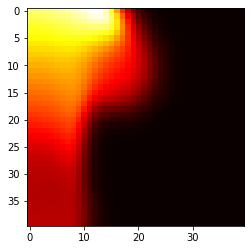

In [24]:
plt.imshow(simb_net.netGenerateMap(imgs[2400], change=False), cmap='hot')

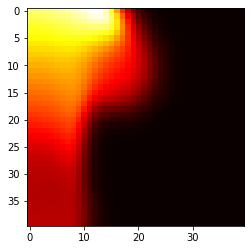

In [25]:
plt.imshow(simb_net.netGenerateMap(imgs[2400], change=False), cmap='hot')

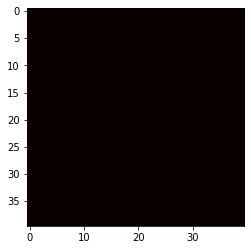

In [13]:
plt.imshow(simb_net.netGenerateMap(imgs[27000], change=True), cmap='hot')

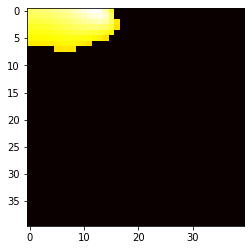

In [14]:
simb_net = SymbolicNet(model)
simb_net.netLoad("/home/gustavo/JUPITER-LAB/networks/net_VGG19_3_40", model)

plt.imshow(simb_net.netGenerateMap(imgs[2400], change=False), cmap='hot')

In [ ]:
plt.imshow(simb_net.netGenerateMap(imgs[27000], change=False), cmap='hot')

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output

tota_number = 10

plt.figure()
for _ in range(len(total_number)):
    random_index = randint(train_num:)
    img=mpimg.imread('/home/gustavo/JUPITER-LAB/images/val2017/'+imgs[random_index])
    plt.imshow(img)
    plt.show()
    plt.imshow(simb_net.netGenerateMap(imgs[random_index], change=False), cmap='hot')
    plt.show()
    clear_output(wait=True)

SyntaxError: invalid syntax (<ipython-input-11-54f5c5cee388>, line 9)

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()

<IPython.core.display.Javascript object>